In [ ]:
'''
결측값 제거
'''

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# 파일 경로 설정
file_path = '찐막.xlsx'

# 엑셀 파일 로드
data_new = pd.read_excel(file_path, sheet_name='Sheet1')

# 'Date' 컬럼 제외한 숫자형 데이터 선택
data_new_numeric = data_new.select_dtypes(include=[np.number])

def central_value(column):
    if column.dtype.kind in 'biufc':  # check if the column is of numeric type
        return np.nanmedian(column)
    else:
        return column.dropna().mode()[0]

def knn_impute(data, k=10):
    # KNN 임퓨터 적용
    imputer = KNNImputer(n_neighbors=k)
    data_imputed = imputer.fit_transform(data)
    data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
    
    # 남아있는 NaN 값을 중앙값으로 채우기
    for col in data.columns:
        if data_imputed[col].isnull().any():
            data_imputed[col] = data_imputed[col].fillna(central_value(data[col]))
    
    return data_imputed

# 임퓨테이션 함수 적용
data_imputed_new = knn_impute(data_new_numeric)

# 결과를 CSV 파일로 저장
output_file_path = 'imputed_data_fixed.csv'
data_imputed_new.to_csv(output_file_path, index=False)

print(f'결과가 {output_file_path}에 저장되었습니다.')


결과가 imputed_data_fixed.csv에 저장되었습니다.


In [ ]:
'''
PCA - 종가
'''

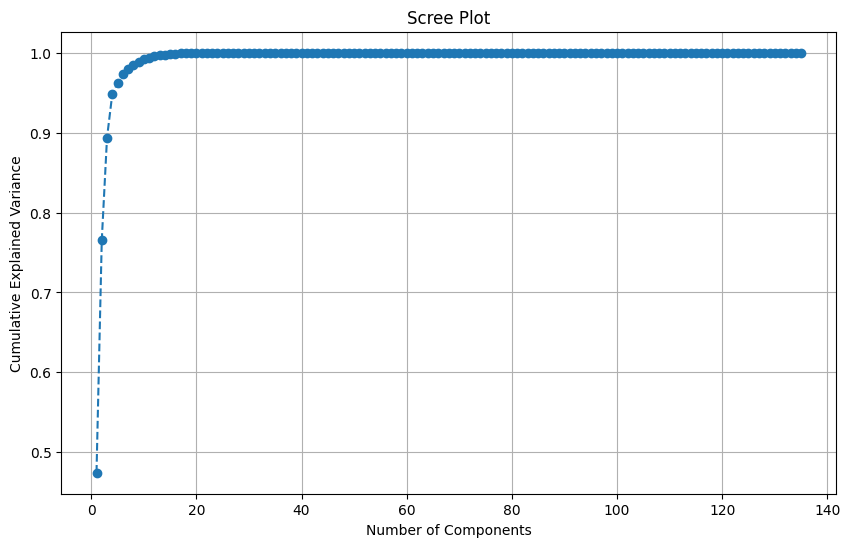

Cumulative Explained Variance by Component:
Number of Components: 1, Cumulative Explained Variance: 0.4744
Number of Components: 2, Cumulative Explained Variance: 0.7651
Number of Components: 3, Cumulative Explained Variance: 0.8937
Number of Components: 4, Cumulative Explained Variance: 0.9483
Number of Components: 5, Cumulative Explained Variance: 0.9618
Number of Components: 6, Cumulative Explained Variance: 0.9728
Number of Components: 7, Cumulative Explained Variance: 0.9801
Number of Components: 8, Cumulative Explained Variance: 0.9849
Number of Components: 9, Cumulative Explained Variance: 0.9886
Number of Components: 10, Cumulative Explained Variance: 0.9917
Number of Components: 11, Cumulative Explained Variance: 0.9937
Number of Components: 12, Cumulative Explained Variance: 0.9956
Number of Components: 13, Cumulative Explained Variance: 0.9967
Number of Components: 14, Cumulative Explained Variance: 0.9976
Number of Components: 15, Cumulative Explained Variance: 0.9983
Numbe

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 파일 경로
file_path = 'data.csv'

# 데이터 로드
data = pd.read_csv(file_path)

# 비정량 데이터 제거
data_numeric = data.select_dtypes(include=[np.number])

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Adj Close를 중심으로 PCA 수행
pca = PCA()
principal_components_adj_close = pca.fit_transform(data_scaled)

# 누적 분산 설명 비율
cumulative_variance_adj_close = np.cumsum(pca.explained_variance_ratio_)

# 스크리 플롯 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_adj_close) + 1), cumulative_variance_adj_close, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for Adj Close')
plt.grid()
plt.show()

# 누적 분산 설명 비율 출력
print("Cumulative Explained Variance by Component:")
for i in range(1, len(cumulative_variance_adj_close) + 1):
    if i == 1 or i % 5 == 0 or cumulative_variance_adj_close[i-1] >= 0.7:
        print(f'Number of Components: {i}, Cumulative Explained Variance: {cumulative_variance_adj_close[i-1]:.4f}')

# 적절한 주성분 수 선택 (여기서는 누적 설명 분산 70% 이상을 기준으로 함)
n_components_adj_close = np.argmax(cumulative_variance_adj_close >= 0.7) + 1

# 선택한 주성분 수로 PCA 재수행
pca = PCA(n_components=n_components_adj_close)
principal_components_adj_close = pca.fit_transform(data_scaled)

# PCA 로딩 매트릭스
loading_matrix_adj_close = pca.components_

# Varimax 회전 함수
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    p, k = Phi.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u, s, vh = np.linalg.svd(np.dot(Phi.T, np.asarray(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T, Lambda))))))
        R = np.dot(u, vh)
        d = np.sum(s)
        if d_old != 0 and d/d_old < 1 + tol:
            break
    return np.dot(Phi, R)

# Varimax 회전 적용
rotated_loading_matrix_adj_close = varimax(loading_matrix_adj_close.T).T

# 회전된 성분 계산
rotated_components_adj_close = np.dot(data_scaled, rotated_loading_matrix_adj_close.T)
rotated_components_adj_close_df = pd.DataFrame(rotated_components_adj_close)

# 로딩 매트릭스를 데이터프레임으로 변환
loading_df_adj_close = pd.DataFrame(rotated_loading_matrix_adj_close, columns=data_numeric.columns[:len(rotated_loading_matrix_adj_close[0])])

# 주요 변수를 각 주성분별로 확인 (상관계수가 0.5 이상인 변수)
significant_variables_adj_close = {}
for i, component in loading_df_adj_close.iterrows():
    significant_vars = component[component.abs() > 0.5]
    significant_vars = significant_vars.sort_values(ascending=False, key=abs)
    significant_variables_adj_close[f'Component {i+1}'] = significant_vars

# 주요 변수 출력 및 저장
significant_variables_adj_close_df = pd.DataFrame({k: pd.Series(v) for k, v in significant_variables_adj_close.items()})
significant_variables_adj_close_df.to_csv('/mnt/data/significant_variables_adj_close.csv', index=False)
rotated_components_adj_close_df.to_csv('/mnt/data/rotated_components_adj_close.csv', index=False)


In [ ]:
'''
PCA - 코스피
'''

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Kospi를 중심으로 PCA 수행
pca = PCA()
principal_components_kospi = pca.fit_transform(data_scaled)

# 누적 분산 설명 비율
cumulative_variance_kospi = np.cumsum(pca.explained_variance_ratio_)

# 스크리 플롯 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_kospi) + 1), cumulative_variance_kospi, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for Kospi')
plt.grid()
plt.show()

# 누적 분산 설명 비율 출력
print("Cumulative Explained Variance by Component:")
for i in range(1, len(cumulative_variance_kospi) + 1):
    if i == 1 or i % 5 == 0 or cumulative_variance_kospi[i-1] >= 0.7:
        print(f'Number of Components: {i}, Cumulative Explained Variance: {cumulative_variance_kospi[i-1]:.4f}')

# 적절한 주성분 수 선택 (여기서는 누적 설명 분산 70% 이상을 기준으로 함)
n_components_kospi = np.argmax(cumulative_variance_kospi >= 0.7) + 1

# 선택한 주성분 수로 PCA 재수행
pca = PCA(n_components=n_components_kospi)
principal_components_kospi = pca.fit_transform(data_scaled)

# PCA 로딩 매트릭스
loading_matrix_kospi = pca.components_

# Varimax 회전 적용
rotated_loading_matrix_kospi = varimax(loading_matrix_kospi.T).T

# 회전된 성분 계산
rotated_components_kospi = np.dot(data_scaled, rotated_loading_matrix_kospi.T)
rotated_components_kospi_df = pd.DataFrame(rotated_components_kospi)

# 로딩 매트릭스를 데이터프레임으로 변환
loading_df_kospi = pd.DataFrame(rotated_loading_matrix_kospi, columns=data_numeric.columns[:len(rotated_loading_matrix_kospi[0])])

# 주요 변수를 각 주성분별로 확인 (상관계수가 0.5 이상인 변수)
significant_variables_kospi = {}
for i, component in loading_df_kospi.iterrows():
    significant_vars = component[component.abs() > 0.5]
    significant_vars = significant_vars.sort_values(ascending=False, key=abs)
    significant_variables_kospi[f'Component {i+1}'] = significant_vars

# 주요 변수 출력 및 저장
significant_variables_kospi_df = pd.DataFrame({k: pd.Series(v) for k, v in significant_variables_kospi.items()})
significant_variables_kospi_df.to_csv('/mnt/data/significant_variables_kospi.csv', index=False)
rotated_components_kospi_df.to_csv('/mnt/data/rotated_components_kospi.csv', index=False)


In [ ]:
'''
corr
'''

/var/folders/67/3p3d9vvj1z74zljvrs594pch0000gn/T/ipykernel_6345/3893164704.py:47: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  plt.tight_layout()
/var/folders/67/3p3d9vvj1z74zljvrs594pch0000gn/T/ipykernel_6345/3893164704.py:47: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.tight_layout()
/var/folders/67/3p3d9vvj1z74zljvrs594pch0000gn/T/ipykernel_6345/3893164704.py:47: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.tight_layout()
/var/folders/67/3p3d9vvj1z74zljvrs594pch0000gn/T/ipykernel_6345/3893164704.py:47: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from current font.
  plt.tight_layout()
/var/folders/67/3p3d9vvj1z74zljvrs594pch0000gn/T/ipykernel_6345/3893164704.py:47: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
/var/folders/67/3p3d9vvj1z74zljvrs594pch0000gn/T/ipykernel_6345/3893164704.py:47: UserWar

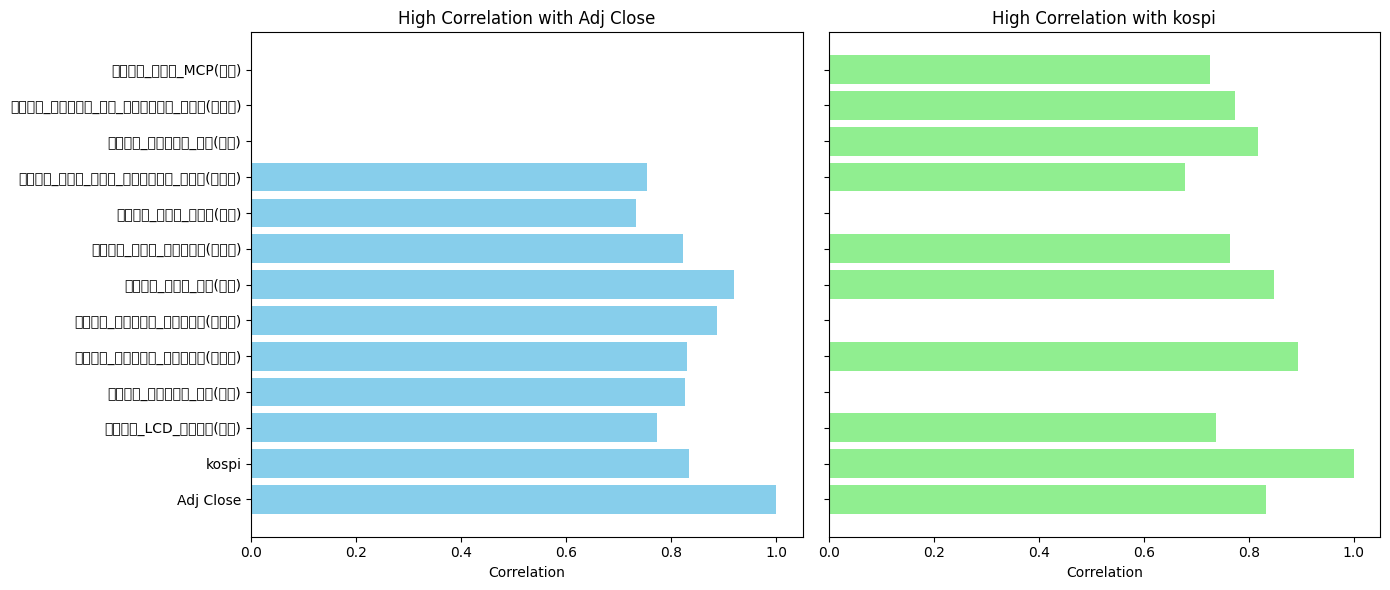

In [18]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로 설정
file_path = 'data.csv'  # 주피터 노트북에서 파일이 있는 경로로 변경 필요

# CSV 파일 불러오기
data = pd.read_csv(file_path)

# 상관관계 행렬 계산
correlation_matrix = data.corr()

# 상관관계가 높은 변수 추출
columns_of_interest = correlation_matrix.columns[:3]
subset_correlation_matrix = data.corr()[columns_of_interest].abs()
high_corr_with_subset = subset_correlation_matrix.apply(lambda x: x.sort_values(ascending=False).head(10))

# 조정 종가와 코스피 지수와의 상관관계 계산
correlation_with_adj_close_kospi = data.corr()[['Adj Close', 'kospi']].abs()
high_corr_with_adj_close_kospi = correlation_with_adj_close_kospi.apply(lambda x: x.sort_values(ascending=False).head(10))

# 상관관계 높은 변수 데이터프레임으로 변환
high_corr_adj_close = high_corr_with_adj_close_kospi['Adj Close'].dropna().to_dict()
high_corr_kospi = high_corr_with_adj_close_kospi['kospi'].dropna().to_dict()
high_corr_combined = pd.DataFrame({
    'Adj Close': high_corr_adj_close,
    'kospi': high_corr_kospi
}).reset_index().rename(columns={'index': 'Variable'})

# CSV 파일로 저장
high_corr_combined.to_csv('high_correlation_adj_close_kospi.csv', index=False)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 조정 종가와의 상관관계 그래프
ax[0].barh(list(high_corr_adj_close.keys()), list(high_corr_adj_close.values()), color='skyblue')
ax[0].set_title('High Correlation with Adj Close')
ax[0].set_xlabel('Correlation')

# 코스피 지수와의 상관관계 그래프
ax[1].barh(list(high_corr_kospi.keys()), list(high_corr_kospi.values()), color='lightgreen')
ax[1].set_title('High Correlation with kospi')
ax[1].set_xlabel('Correlation')

plt.tight_layout()
plt.savefig('high_correlation_adj_close_kospi.png')
plt.show()


In [4]:
'''
corr + 리니어
'''

SyntaxError: incomplete input (1519222820.py, line 1)

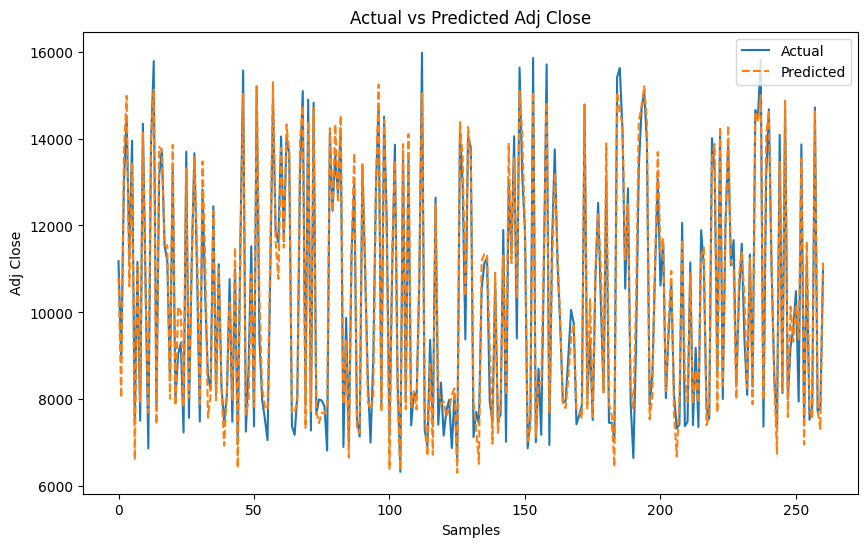

Mean Squared Error: 273965.4009637404
R² Score: 0.9641820287966604


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 불러오기
data = pd.read_csv('data.csv')

# 공통 변수들과 코스피 지수를 포함한 데이터셋 생성
common_high_corr_vars = [
    '산업동향_반도체_생산(조원)', 
    '산업동향_디스플레이_시장점유율(퍼센트)', 
    '산업동향_디스플레이_수출증가율(퍼센트)', 
    '산업동향_디스플레이_수입(억불)', 
    '산업동향_반도체_수입증가율(퍼센트)', 
    '산업동향_LCD_평균가격(달러)', 
    '수출동향_시스템_반도체_전년동월대비_증감률(퍼센트)', 
    '수출동향_시스템_반도체(억불)',
    'kospi',
    'Adj Close'
]

# 데이터 필터링
data = data[common_high_corr_vars]

# 결측치 제거
data = data.dropna()

# 독립 변수(X)와 종속 변수(y) 설정
X = data.drop('Adj Close', axis=1)
y = data['Adj Close']

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 회귀 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Adj Close')
plt.xlabel('Samples')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

# MSE와 R² 출력
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


In [ ]:
'''
트랜스포머
'''

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('data.csv')

# 사용할 변수들 선택
features = [
    'ExgRate', 'kospi', '산업동향_반도체_생산(조원)', '산업동향_반도체_시장점유율(퍼센트)', 
    '산업동향_반도체_수출(억불)', '산업동향_반도체_수출증가율(퍼센트)', '산업동향_반도체_수입(억불)',
    '산업동향_반도체_수입증가율(퍼센트)', '산업동향_DRAM_가격(달러)', '산업동향_디스플레이_시장점유율(퍼센트)',
    '산업동향_디스플레이_수출증가율(퍼센트)', '산업동향_디스플레이_수입(억불)', '산업동향_LCD_평균가격(달러)',
    '수출동향_시스템_반도체_전년동월대비_증감률(퍼센트)', '수출동향_시스템_반도체(억불)', 'Adj Close'
]

data = data[features]

# 결측치 제거
data = data.dropna()

# 데이터 스케일링
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 시계열 데이터셋 생성
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        x = self.data[index:index+self.seq_length, :-1]
        y = self.data[index+self.seq_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 시퀀스 길이 설정
seq_length = 30

# 데이터셋 및 데이터로더 생성
dataset = TimeSeriesDataset(data_scaled, seq_length)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.seq_length = seq_length
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, model_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, 1)
        
    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x.squeeze()

# 모델 파라미터 설정
input_dim = len(features) - 1
model_dim = 64
nhead = 8
num_layers = 4

model = TransformerModel(input_dim, model_dim, nhead, num_layers, seq_length).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

# 모델 평가 및 시각화
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Adj Close')
plt.xlabel('Samples')
plt.ylabel('Adj Close')
plt.legend()
plt.show()


In [ ]:
'''추가 코드'''

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('data.csv')

# 사용할 변수들 선택
features = [
    'ExgRate', 'kospi', '산업동향_반도체_생산(조원)', '산업동향_반도체_시장점유율(퍼센트)', 
    '산업동향_반도체_수출(억불)', '산업동향_반도체_수출증가율(퍼센트)', '산업동향_반도체_수입(억불)',
    '산업동향_반도체_수입증가율(퍼센트)', '산업동향_DRAM_가격(달러)', '산업동향_디스플레이_시장점유율(퍼센트)',
    '산업동향_디스플레이_수출증가율(퍼센트)', '산업동향_디스플레이_수입(억불)', '산업동향_LCD_평균가격(달러)',
    '수출동향_시스템_반도체_전년동월대비_증감률(퍼센트)', '수출동향_시스템_반도체(억불)', 'Adj Close'
]

data = data[features]

# 결측치 제거
data = data.dropna()

# 데이터 스케일링
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 시계열 데이터셋 생성
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        x = self.data[index:index+self.seq_length, :-1]
        y = self.data[index+self.seq_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 시퀀스 길이 설정
seq_length = 30

# 데이터셋 및 데이터로더 생성
dataset = TimeSeriesDataset(data_scaled, seq_length)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.seq_length = seq_length
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, model_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, 1)
        
    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x.squeeze()

# 모델 파라미터 설정
input_dim = len(features) - 1
model_dim = 64
nhead = 8
num_layers = 4

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerModel(input_dim, model_dim, nhead, num_layers, seq_length).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

# 모델 평가 및 시각화
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Adj Close')
plt.xlabel('Samples')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

# MSE와 R² 출력
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
